In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2

In [2]:
folder_list=os.listdir("Image/wrinkles")

In [3]:
folder_list

['Not wrinkled', 'wrinkled']

In [4]:
features_train=[]
target_train=[]
for folder in folder_list:
    ImgNames_list=os.listdir("Image/wrinkles"+"/"+folder+"/")
    print("In Folder : ",folder)
    for imgName in ImgNames_list:
        Imgarr=cv2.imread("Image/wrinkles"+"/"+folder+"/"+imgName)
        # there might be images of size less than 100 by 100 and so error occurs
        try:
            Imgarr=cv2.resize(Imgarr,(100,100))
        except: # we need to write atleast one line of code
            pass
        else:
            features_train.append(Imgarr)
            if folder=="Not Wrinkled":
                target_train.append(0)
            else:
                target_train.append(1)

In Folder :  Not wrinkled
In Folder :  wrinkled


In [5]:
features_train=np.array(features_train)
target_train=np.array(target_train)

In [6]:
features_train.shape

(377, 100, 100, 3)

In [7]:
target_train.shape

(377,)

In [8]:
features_train.ndim

4

In [9]:
target_train.ndim

1

In [10]:
def preprocessing(image):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image=image/255
    return image

In [11]:
features_train=np.array(list(map(preprocessing,features_train)))

In [12]:
features_train.shape

(377, 100, 100)

In [13]:
features_train=features_train.reshape(377, 100, 100,1)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
dataGen=ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,shear_range=0.1)

In [16]:
dataGen.fit(features_train)

In [17]:
batches=dataGen.flow(features_train,target_train,batch_size=5)

In [18]:
len(batches)

76

In [19]:
images,labels=next(batches)

In [20]:
images.ndim

4

In [21]:
labels.shape

(5,)

In [22]:
images.shape

(5, 100, 100, 1)

In [23]:
import matplotlib.pyplot as plt

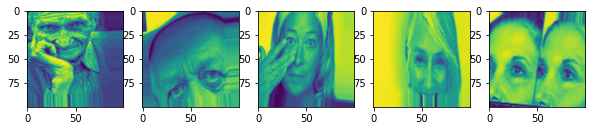

In [24]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i].reshape(100,100))
plt.show()

In [25]:
features_train.shape

(377, 100, 100, 1)

In [26]:
target_train.shape

(377,)

In [27]:
from keras.utils.np_utils import to_categorical

In [28]:
target_train=to_categorical(target_train)

In [29]:
target_train.shape

(377, 2)

In [30]:
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential

In [31]:
model=Sequential()
model.add(Conv2D(100,(3,3),activation="relu",input_shape=(100,100,1)))
model.add(Conv2D(100,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(50,(3,3),activation="relu"))
model.add(Conv2D(50,(3,3),activation="relu"))
model.add(Conv2D(50,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))

#model.add(Dropout(0.5)) # for overfitting model

model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax")) 

In [32]:
from keras.optimizers import Adam

In [33]:
model.compile(Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

In [34]:
model.fit(dataGen.flow(features_train,target_train,batch_size=5),epochs=5)

Epoch 1/5
76/76 [==============================] - 40s 379ms/step - loss: 0.1037 - accuracy: 0.9872
Epoch 2/5
76/76 [==============================] - 34s 452ms/step - loss: 2.7837e-07 - accuracy: 1.0000
Epoch 3/5
76/76 [==============================] - 29s 385ms/step - loss: 2.2321e-06 - accuracy: 1.0000
Epoch 4/5
76/76 [==============================] - 31s 408ms/step - loss: 1.0541e-06 - accuracy: 1.0000
Epoch 5/5
76/76 [==============================] - 31s 401ms/step - loss: 2.1513e-07 - accuracy: 1.0000


In [35]:
model_json=model.to_json() # converted to json file
with open("Wrinkle.json","w") as abc:
    abc.write(model_json)
    abc.close()
model.save_weights("WrinkleWeights.h5") # saving weights as hdf 5 file
print("Save the Model")

Save the Model


In [36]:
from keras.models import model_from_json
json_file=open("Wrinkle.json","r")
loaded_model_json=json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)
loaded_model.load_weights("WrinkleWeights.h5")
print("Loaded model successfully")

Loaded model successfully


In [37]:
def getClassName(classNo):
    if classNo == 0: return "No Wrinkles"
    elif classNo == 1: return "Wrinkled"

In [38]:
import cv2
image=cv2.imread("Desktop/cricket.jpg")

In [39]:
cv2.imshow("cricket",image)
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [40]:
face_cascade=cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [41]:
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
faces=face_cascade.detectMultiScale(gray,1.05,15) # 5% reduction , iff the rectangle identifies the face 3 times
for (x,y,w,h) in faces: # x,y->coordinates of rectangles on faces, w-> width of rectangle, h->height of rectangle
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
img=image[x:x+w,y:y+h]

In [42]:
imagearr=cv2.resize(img,(100,100))
imagearr=preprocessing(imagearr)
imagearr=imagearr.reshape((1,100,100,1)) 
predictions=loaded_model.predict(imagearr)
classIndex=loaded_model.predict_classes(imagearr)
probValue=np.amax(predictions)
cv2.putText(image,"Class: ",(20,25),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255)) 
cv2.putText(image,"Probability: ",(20,65),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255))
if probValue>0.75:
    cv2.putText(image,getClassName(classIndex),(120,25),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),1)
    cv2.putText(image,str(int(probValue*100))+" %",(200,65),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
cv2.imshow("Model Prediction",image)
key=cv2.waitKey(0)
if key==ord("\r"):
    cv2.destroyAllWindows()

C:\Users\SANTHOSH\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
